In [194]:
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [109]:
league_id = 119974
prev_year = 2019

prev_url = "https://fantasy.espn.com/apis/v3/games/ffl/leagueHistory/" + \
      str(league_id) + "?seasonId=" + str(prev_year)

current_url = 'https://fantasy.espn.com/apis/v3/games/ffl/seasons/2019/segments/0/leagues/' + str(league_id)

teams = requests.get(current_url, cookies).json()
matches = requests.get(current_url, params={"view": "mMatchup"}).json()

In [111]:
df = [[
        game['matchupPeriodId'],
        game['home']['teamId'], game['home']['totalPoints'],
        game['away']['teamId'], game['away']['totalPoints']
    ] for game in matches['schedule']]
df = pd.DataFrame(df, columns=['Week', 'Team1', 'Score1', 'Team2', 'Score2'])
df['Type'] = ['Regular' if w<=14 else 'Playoff' for w in df['Week']]
df.head()

,Week,Team1,Score1,Team2,Score2,Type
0,1,3,84.06,9,86.92,Regular
1,1,11,130.32,1,128.06,Regular
2,1,8,85.34,7,110.92,Regular
3,1,2,84.16,12,116.12,Regular
4,1,6,105.92,5,150.40,Regular


In [120]:
id_to_names = {}
for i in teams['teams']:
    print(i)
    id_to_names[i['id']] = i['location'] + ' ' + i['nickname']

{'abbrev': 'HSD', 'id': 1, 'location': 'Hot Single', 'nickname': 'Dads', 'owners': ['{A5175F0E-F231-4612-9781-872E34BD928D}']}
{'abbrev': 'PIZA', 'id': 2, 'location': 'The horses', 'nickname': 'in the back', 'owners': ['{5E5DFF3F-7DBD-446D-BA83-0FF2E9F6A04E}']}
{'abbrev': 'John', 'id': 3, 'location': 'Kittle', 'nickname': 'My Johnson', 'owners': ['{0AA3B4F7-574C-4B85-A65D-AD3B686BF2E9}']}
{'abbrev': 'AT', 'id': 5, 'location': 'Razor', 'nickname': 'Gang', 'owners': ['{F338FE61-A002-4C2C-B135-11EE25A92293}']}
{'abbrev': 'CUNI', 'id': 6, 'location': 'The ', 'nickname': 'Lizard King', 'owners': ['{A9DDB5D2-34F5-436F-BFB0-F995FBB07EEC}']}
{'abbrev': 'BEAT', 'id': 7, 'location': "Tyreek Hill's", 'nickname': 'Daycare', 'owners': ['{07F427F1-3952-4D5A-87A4-5CFF9223EFA1}']}
{'abbrev': 'JPOW', 'id': 8, 'location': 'Sad', 'nickname': 'Adams', 'owners': ['{5B6BD7FF-7AF2-48BF-A2AF-E428B1D43B05}']}
{'abbrev': 'GOLD', 'id': 9, 'location': 'Two Ds', 'nickname': 'Four QBs', 'owners': ['{05E0DDEE-ACB4-4

In [184]:
games = df.replace({'team1': id_to_names, 'team2': id_to_names})

In [136]:
df3 = df.assign(Margin1 = df['Score1'] - df['Score2'],
                Margin2 = df['Score2'] - df['Score1'])
df3 = (df3[['Week', 'Team1', 'Margin1', 'Type']]
 .rename(columns={'Team1': 'Team', 'Margin1': 'Margin'})
 .append(df3[['Week', 'Team2', 'Margin2', 'Type']]
 .rename(columns={'Team2': 'Team', 'Margin2': 'Margin'}))
)
df3.head()

,Week,Team,Margin,Type
0,1,3,-2.86,Regular
1,1,11,2.26,Regular
2,1,8,-25.58,Regular
3,1,2,-31.96,Regular
4,1,6,-44.48,Regular


In [182]:
margins = df3.replace({'Team':id_to_names})

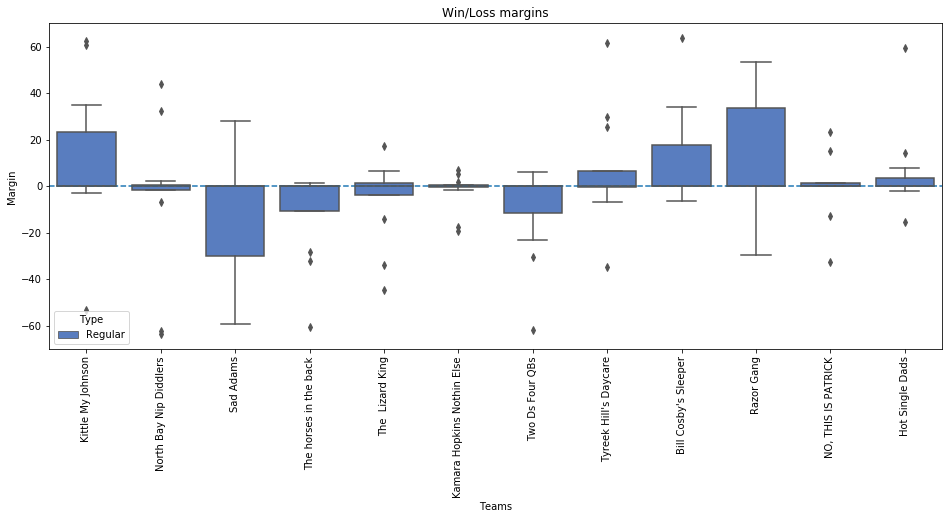

In [215]:
fig, ax = plt.subplots(1,1, figsize=(16,6))
sns.boxplot(x='Team', y='Margin', hue='Type',
            data=margins,
            palette='muted')
ax.axhline(0, ls='--')
ax.set_xlabel('Teams')
ax.set_title('Win/Loss margins')
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
plt.show()

In [216]:
avgs = (df
 .filter(['Week', 'Score1', 'Score2'])
 .melt(id_vars=['Week'], value_name='Score')
 .groupby('Week')
 .mean()
 .reset_index()
)
avgs.head()

,Week,Score
0,1,106.576667
1,2,96.968333
2,3,112.088333
3,4,94.213333
4,5,113.701667


In [217]:
tm = 9

# grab all games with this team
df2 = df.query('Team1 == @tm | Team2 == @tm').reset_index(drop=True)

# move the team of interest to "Team1" column
ix = list(df2['Team2'] == tm)
df2.loc[ix, ['Team1','Score1','Team2','Score2']] = \
    df2.loc[ix, ['Team2','Score2','Team1','Score1']].values

# add new score and win cols
df2 = (df2
 .assign(Chg1 = df2['Score1'] - avgs['Score'],
         Chg2 = df2['Score2'] - avgs['Score'],
         Win  = df2['Score1'] > df2['Score2'])
)

In [218]:
df2

,Week,Team1,Score1,Team2,Score2,Type,team1_names,team2_names,Chg1,Chg2,Win
0,1,9.0,86.92,3.0,84.06,Regular,Kittle My Johnson,Two Ds Four QBs,-19.656667,-22.516667,True
1,2,9.0,118.06,1.0,125.78,Regular,Two Ds Four QBs,Hot Single Dads,21.091667,28.811667,False
2,3,9.0,92.80,7.0,154.52,Regular,Tyreek Hill's Daycare,Two Ds Four QBs,-19.288333,42.431667,False
3,4,9.0,78.08,12.0,71.90,Regular,Two Ds Four QBs,Bill Cosby's Sleeper,-16.133333,-22.313333,True
4,5,9.0,76.62,5.0,106.92,Regular,Razor Gang,Two Ds Four QBs,-37.081667,-6.781667,False
5,6,9.0,81.10,10.0,104.22,Regular,Two Ds Four QBs,"NO, THIS IS PATRICK",-22.570000,0.550000,False
6,7,9.0,0.00,13.0,0.00,Regular,Kamara Hopkins Nothin Else,Two Ds Four QBs,0.000000,0.000000,False
7,8,9.0,0.00,6.0,0.00,Regular,Two Ds Four QBs,The Lizard King,0.000000,0.000000,False
8,9,9.0,0.00,2.0,0.00,Regular,The horses in the back,Two Ds Four QBs,0.000000,0.000000,False
9,10,9.0,0.00,8.0,0.00,Regular,Two Ds Four QBs,Sad Adams,0.000000,0.000000,False
